In [1]:
#unsupervise
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from unnet_celeb import CapsNetWithReconstruction, CapsNet, ReconstructionNet

data = datasets.ImageFolder('../data/celeba/img_align_celeba',
                            transform=transforms.Compose([transforms.CenterCrop((128,128)), transforms.Resize((64,64)),transforms.ToTensor()]))
# data = datasets.ImageFolder('../data/rendered_chairs',
#                             transform=transforms.Compose([transforms.Grayscale(), transforms.Resize((64,64)),transforms.ToTensor()]))
dataset = DataLoader(data, batch_size=128, shuffle=True)
                            
capsnet = CapsNet(routing_iterations=3, n_classes=1, capsuleblock=64, n_dim=32)
reconstructionnet = ReconstructionNet(n_dim=32, n_classes=1)
model = CapsNetWithReconstruction(capsnet, reconstructionnet)

MODEL_PATH = r'trained_model\CelebA_centercrop_100epoch_dim32_kl1_rec0.0065_kl0.00001811.pth'
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [2]:
import numpy as np
from scipy import stats
from torch.autograd import Variable
from torchvision.utils import make_grid, save_image

class Visualizer():
    def __init__(self, model):
        self.model = model
        self.save_images = False  # If false, each method returns a tensor instead of saving image.

    def reconstructions(self, data, labels, size=(8, 8), filename='recon.png'):
        self.model.eval()  
        with torch.no_grad():
            input_data = data
            input_labels = labels
        recon_data, *datas = self.model(input_data)
        self.model.train()    
        num_images = int(size[0] * size[1] / 2)
        originals = input_data[:num_images].cpu()
        reconstructions = recon_data.view(-1, data.size()[1], data.size()[2], data.size()[3])[:num_images].cpu()
        num_examples = originals.size()[0]   
        if num_images > num_examples:   # input_data[:num_images]超出索引范围也不会报错，但input_data[num_images]超出索引会报错
            blank_images = torch.zeros((num_images - num_examples,) + originals.size()[1:])
            originals = torch.cat([originals, blank_images])
            reconstructions = torch.cat([reconstructions, blank_images])
        comparison = torch.cat([originals, reconstructions])
        save_image(comparison.data, filename, nrow=size[0])
        return make_grid(comparison.data, nrow=size[0])   # make_grid返回值是tensor
    
    def samples(self, class_caps, size=(16, 10), filename='samples.png', range_=(0.4,0.4), traverser=10):
        sample_squ = class_caps.squeeze(0)
        sample = sample_squ.detach().numpy().squeeze(0)#class_caps(1,16), sample(16,)
        n_dim = sample.shape[0]     #dim of each class capsule
        cdf_traversal = np.linspace(range_[0], range_[1], traverser)
        samples = []
        for i in range(n_dim):
            for j in range(traverser):
                sample_copy = sample.copy()
                sample_copy[i] = cdf_traversal[j] + sample_squ[0,i].detach().numpy()
                #sample_copy[i] = cdf_traversal[j]
                samples.append(sample_copy)
        return torch.Tensor(samples)#.view(-1, n_dim)
    

# (1x28x28 tensor input)
def get_digit_caps(model, image):
    input_ = Variable(image.unsqueeze(0), volatile=True)
    digit_caps = model.capsnet(input_)
    return digit_caps
    
# takes digit_caps output
def get_reconstruction(model, digit_caps):
    reconstruction, klloss = model.reconstruction_net(digit_caps)
    return reconstruction.data.cpu().numpy()#.reshape(28, 28)    

In C:\Users\hmf\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hmf\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hmf\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\hmf\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\hmf\Miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

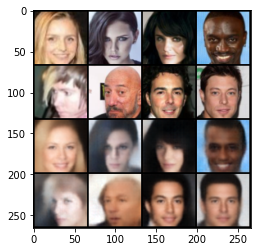

In [3]:
viz = Visualizer(model)

%matplotlib inline
import matplotlib.pyplot as plt

# Get a batch of data
for batch, labels in dataset:
    break
    
# Reconstruct data (bottom half)
recon = viz.reconstructions(batch, labels, size=(4, 4))

recon = np.transpose(recon.numpy(), (1, 2, 0))
plt.imshow(recon)

C:\Users\hmf\Miniconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


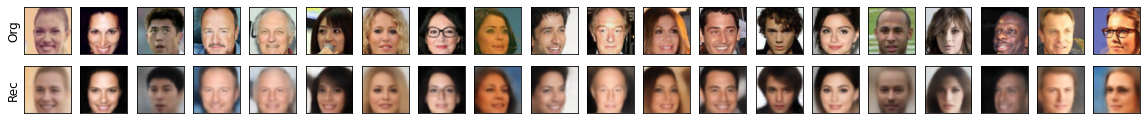

In [4]:
dataset1 = DataLoader(data, batch_size=128, shuffle=True)
for batch1, labels1 in dataset1:
    break
images = []
reconstructions = []
for i in range(20):
    image_tensor = batch1[i]
    digit_caps = get_digit_caps(model, image_tensor)
    reconstruction = get_reconstruction(model, digit_caps)
    images.append(np.transpose(image_tensor.numpy(), (1,2,0)))
    reconstructions.append(np.transpose(reconstruction.reshape(3,64,64), (1,2,0)))
    
fig, axs = plt.subplots(2, 20, figsize=(20, 2))
axs[0, 0].set_ylabel('Org', size='large')
axs[1, 0].set_ylabel('Rec', size='large')
for i in range(20):
    axs[0, i].imshow(images[i], cmap ='gray')
    axs[1, i].imshow(reconstructions[i], cmap ='gray')
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])

C:\Users\hmf\Miniconda3\lib\site-packages\ipykernel_launcher.py:47: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


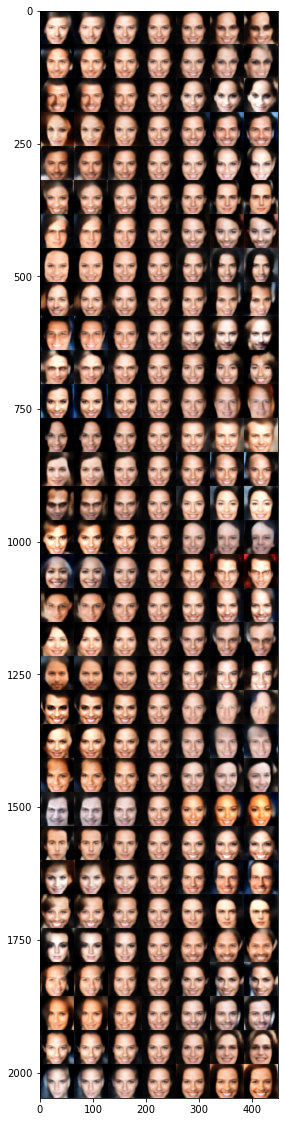

In [6]:
from torchvision.utils import make_grid
i=1
image_tensor = batch1[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.04,0.04), traverser=7)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 3, 64, 64)
gene = make_grid(generate.data, nrow=7, padding=0).detach().numpy()
plt.rcParams['figure.figsize'] = (16, 8)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(gene, (1,2,0)))
save_image(generate.data, 'our0.png', nrow=7, padding=0)

In [ ]:
i=19
image_tensor = batch1[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.00,0.04), traverser=7)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 3, 64, 64)
gene = make_grid(generate.data, nrow=7, padding=0).detach().numpy()
plt.rcParams['figure.figsize'] = (16, 8)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(gene, (1,2,0)))
save_image(generate.data, 'our0.png', nrow=7, padding=0)

In [ ]:
save_subimage(generate, raw=11, name='masculinity', num=10)

In [ ]:
1 color 
2 baldness
4 gender -0.04 0
6 width
7 bangs
10 brightness
11 masculinity
12 glasses
13 azimuth
15 smile
16 hue

In [ ]:
def save_subimage(generate, raw, name, num=1):
    a = (raw-1)*7
    b = raw*7
    save_image(generate[a:b,:,:,:].data, './CelebA/{}{}.png'.format(name, num), nrow=7, padding=0)

In [ ]:
dataset2 = DataLoader(data, batch_size=128, shuffle=False)
for batch2, labels2 in dataset2:
    break
images = []
reconstructions = []
for i in range(20):
    image_tensor = batch2[i]
    digit_caps = get_digit_caps(model, image_tensor)
    reconstruction = get_reconstruction(model, digit_caps)
    images.append(np.transpose(image_tensor.numpy(), (1,2,0)))
    reconstructions.append(np.transpose(reconstruction.reshape(3,64,64), (1,2,0)))
    
fig, axs = plt.subplots(2, 20, figsize=(20, 2))
axs[0, 0].set_ylabel('Org', size='large')
axs[1, 0].set_ylabel('Rec', size='large')
for i in range(20):
    axs[0, i].imshow(images[i], cmap ='gray')
    axs[1, i].imshow(reconstructions[i], cmap ='gray')
    axs[0, i].set_yticks([])
    axs[0, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].set_xticks([])

In [ ]:
i = 5
image_tensor = batch2[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.02,0.01), traverser=7)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 3, 64, 64)
gene = make_grid(generate.data, nrow=7, padding=0).detach().numpy()
plt.rcParams['figure.figsize'] = (16, 8)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(gene, (1,2,0)))
save_image(generate.data, 'our1.png', nrow=7, padding=0)

In [ ]:
i=1
image_tensor = batch[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.02,0.02), traverser=7)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 1, 64, 64)
gene = make_grid(generate.data, nrow=7, padding=0).detach().numpy()
plt.rcParams['figure.figsize'] = (16, 8)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(gene, (1,2,0)))
save_image(generate.data, 'our1.png', nrow=7, padding=0)

In [ ]:
from torchvision.utils import make_grid
i=1
image_tensor, label = data[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.2,0.2), traverser=10)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 1, 28, 28)
gene = make_grid(generate.data, nrow=10)
plt.rcParams['figure.figsize'] = (16, 8)
plt.imshow(gene.detach().numpy()[0, :, :], cmap='gray')

In [ ]:
from torchvision.utils import make_grid
i=2
image_tensor, label = dataset[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.1,0.1), traverser=10)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 1, 28, 28)
gene = make_grid(generate.data, nrow=10)
plt.rcParams['figure.figsize'] = (16, 8)
plt.imshow(gene.detach().numpy()[0, :, :], cmap='gray')

In [ ]:
from torchvision.utils import make_grid
i=3
image_tensor, label = dataset[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.2,0.2), traverser=10)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 1, 28, 28)
gene = make_grid(generate.data, nrow=10)
plt.rcParams['figure.figsize'] = (16, 8)
plt.imshow(gene.detach().numpy()[0, :, :], cmap='gray')

In [ ]:
from torchvision.utils import make_grid
i=4
image_tensor, label = dataset[i]
digit_caps = get_digit_caps(model, image_tensor)
samples = viz.samples(digit_caps, range_=(-0.2,0.2), traverser=10)
rec_sam,kl = model.reconstruction_net(samples)
generate = rec_sam.view(-1, 1, 28, 28)
gene = make_grid(generate.data, nrow=10)
plt.rcParams['figure.figsize'] = (16, 8)
plt.imshow(gene.detach().numpy()[0, :, :], cmap='gray')